# <font color="red">**Assignment 7 Filtro anti-hater per social network**</font>
Negli ultimi anni, la moderazione dei contenuti online è diventata una sfida cruciale per molte piattaforme, che si trovano ad affrontare un volume crescente di commenti potenzialmente dannosi. Questi commenti possono includere insulti, minacce, contenuti osceni o messaggi di odio. La moderazione manuale è inefficace su larga scala, e gli algoritmi tradizionali spesso non riescono a catturare la complessità e la varietà dei linguaggi offensivi.

# <font color="red">**Problema da risolvere**</font>
L'azienda TechTalk, un forum per appassionati di tecnologia, ha riscontrato che un numero significativo di commenti pubblicati nei thread della community contiene espressioni di odio e insulti che compromettono la qualità delle discussioni. Gli utenti hanno segnalato che la piattaforma, a causa della sua popolarità crescente, fatica a gestire il flusso di commenti dannosi con strumenti di moderazione tradizionali. TechTalk si è rivolta a DeepCortex AI Solutions per implementare una soluzione di moderazione automatica basata su Deep Learning, che sia in grado di filtrare in tempo reale i commenti tossici.

# <font color="red">**Obiettivo del Progetto**</font>
- **Task**: Classificazione multi-label dei commenti in 6 categorie:
 1. Toxic (Tossico)
 2. Severely Toxic (Super Tossico)
 3. Obscene (Osceno)
 4. Threat (Minaccia)
 5. Insult (Insulto)
 6. Identity Hate (Odio basato sull’identità)

- **Dataset**: Un dataset di 160.000 commenti sarà fornito, con ogni commento etichettato in una o più delle categorie sopra indicate. I commenti possono avere zero o più label attive.
- **Architettura**: Il modello deve includere layer ricorrenti (ad esempio, LSTM o GRU) per gestire la natura sequenziale dei commenti testuali.
- **Output**: A livello di inferenza, per ogni commento, il modello dovrà produrre un vettore di 6 elementi (uno per ogni label), con valori binari (0 o 1), dove 1 indica la presenza della label corrispondente e 0 la sua assenza.

In [ ]:
# Import delle librerie necessarie
import os, re, string, sys, json, random, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### <font color="yellow">***Caricamento Dataset & Preprocessing***</font>

In [ ]:
# imposto il seed per riproducibilità dei risultati
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Caricamento Dataset
dataset_url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/Filter_Toxic_Comments_dataset.csv"

df = pd.read_csv(dataset_url)
print("Rows:", len(df))
display(df)

Rows: 159571


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


Dal seguente display vedo come nel dataframe in input sia presente una categoria in più (la sum_injurious), andrò subito a rimuoverla dal dataset in quanto inutile ai fini del progetto.

Inoltre, sempre dal display, vedo solo valori uguali a 0 per le varie categorie. Mi faccio qui sotto uno snippet per capire quanti commenti con valore = 1 ho per categoria

In [ ]:
df = df.drop(columns=['sum_injurious'])
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Conteggio per categoria
label_counts = df[LABELS].sum().sort_values(ascending=False)
print("Numero di commenti per categoria:")
print(label_counts)

Numero di commenti per categoria:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [ ]:
# mi printo alcuni esempi di commenti tossici
pd.set_option('display.max_colwidth', None)
df[df['toxic'] == 1].head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


Per ogni tipologia di categoria ho chiaramento un dataset sbilanciato. C'è un numero molto maggiore di commenti positivi/neutri, rispetto a quelli tossici. (questo fatto andrà preso in considerazione durante il processo di addestramento)

Ora costruisco questa funzione che mi permette di rimuovere tutti i caratteri speciali dai commenti in input e mettere tutto in minuscolo.

In [ ]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"https?:\/\/\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r" +", " ", text).strip()
    return text

In [ ]:
df["comment_text"] = df["comment_text"].apply(clean_text)

#### TOKENIZZAZIONE E PADDING####

Procedo con alcune analisi preliminari per capire quanto potrei mettere come valori per la size del vocabolario e la lunghezza massima dei commenti

In [ ]:
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(df["comment_text"].values)


actual_vocab_size = len(test_tokenizer.word_index)+1
sentence_comments = test_tokenizer.texts_to_sequences(df["comment_text"].values)
maxlen_comment = len(max(sentence_comments,key=len))

In [ ]:
print(f"Lunghezza vocabolario: {actual_vocab_size}")
print(f"Numero massimo di token in un commento: {maxlen_comment}")

Lunghezza vocabolario: 218340
Numero massimo di token in un commento: 1403


In [ ]:
seq_lengths = [len(seq) for seq in sentence_comments]

# Indice del commento più lungo
idx_longest = int(np.argmax(seq_lengths))

# Stampa integrale del testo grezzo
print("\n--- COMMENTO PIÙ LUNGO ---\n")
print(df.loc[idx_longest, 'comment_text'])


--- COMMENTO PIÙ LUNGO ---

do go fuck off bastard do yyou have a life go fuck off bastard and yank your cock through your ass i hate you and hope you go away forever lame is you fuck your mom die die die and all that crap this is for mahy mahonerz ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i 

Effettivamente sembra che ci sia un commento lungo tutte queste parole.

Non so se ci sia stato qualche errore che ha fatto si che "i ass" si ripeta così tante volte, ma potrebbe anche essere che il nostro hater sia stato alquanto incazzato e lo abbia fatto di proposito. Perciò considererò questo commento come reale.

Ora mi printo qualche percentile che mi da informazioni sulla distribuzione della lunghezza dei commenti.

In [ ]:
seq_len = np.array([len(s) for s in test_tokenizer.texts_to_sequences(df["comment_text"])])
for p in (90, 95, 99):
    print(f"{p}° percentile: {np.percentile(seq_len, p):.0f} token")

90° percentile: 149 token
95° percentile: 223 token
99° percentile: 555 token


La lunghezza del commento più lungo (1403 token) chiaramente sarebbe una scelta troppo onerosa dal punto di vista computazionale e di memoria occupata, anche considerando che la parte informativa del commento è molto più corta. In generale poi vedo che il 95% dei commenti ha lunghezza inferiore e 223 token.
Con buona approssimazione direi che possiamo considerare una lunghezza massima per i commenti di 200 token (i più lunghi saranno troncati, ma mi sembra un buon compromesso)

Per quanto riguarda il vocabolario, abbiamo una grandezza un po' eccessiva. Probabilmente, essendo commenti scritti un po' in fretta, ci potrebbero essere molti token che in realtà sono errori di battitura (o dei neologismi che per il nostro modello non avrebbero molto significato) e hanno un numero di occorrenze estremamente basso.

Provo a vedere che numero di token sarebbe necessario avere nel vocabolario per avere comunque il 99% dei token nei vari commenti rappresentati, così da filtrare effettivamente solo quelli con pochissima occorrenze.

                 token   count  cum_count    cum_perc
0                  the  495454     495454    4.746483
1                   to  296838     792292    7.590211
2                   of  224021    1016313    9.736348
3                  and  222362    1238675   11.866591
4                    a  214905    1453580   13.925396
...                ...     ...        ...         ...
218334       leafnodes       1   10438335   99.999962
218335     nearendless       1   10438336   99.999971
218336       dynastyso       1   10438337   99.999981
218337     hanumakonda       1   10438338   99.999990
218338  notnecessarily       1   10438339  100.000000

[218339 rows x 4 columns]
Token totali nel corpus:        10,438,339
Vocabolario per coprire il 99%: 113,956 parole


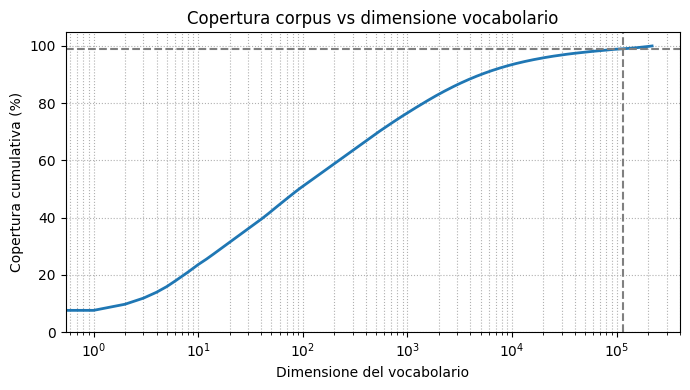

In [ ]:
# Ricaviamo le frequenze dal tokenizer già addestrato
word_counts = test_tokenizer.word_counts

# In DataFrame, ordinato per frequenza decrescente
freq_df = (pd.DataFrame(word_counts.items(), columns=["token", "count"])
             .sort_values("count", ascending=False)
             .reset_index(drop=True))

# Calcoliamo la copertura cumulativa
freq_df["cum_count"] = freq_df["count"].cumsum()
total_tokens = freq_df["count"].sum()
freq_df["cum_perc"] = 100 * freq_df["cum_count"] / total_tokens

print(freq_df)

#  Troviamo la cut-off: prima riga con copertura ≥ 99 %
cutoff_idx = freq_df[freq_df["cum_perc"] >= 99].index[0]
vocab_99 = cutoff_idx + 1

print(f"Token totali nel corpus:        {total_tokens:,}")
print(f"Vocabolario per coprire il 99%: {vocab_99:,} parole")

# Grafico copertura cumulativa
plt.figure(figsize=(7,4))
plt.plot(freq_df["cum_perc"].values, lw=2)
plt.axhline(99, color="gray", linestyle="--")
plt.axvline(cutoff_idx, color="gray", linestyle="--")
plt.xlabel("Dimensione del vocabolario")
plt.ylabel("Copertura cumulativa (%)")
plt.title("Copertura corpus vs dimensione vocabolario")
plt.xscale("log")          # scala log
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


Per coprire il 99% dei token presenti nel corpus dovremmo comunque avere un dizionario estremamente grosso (più di 100k), provo a scendere con la probabilità al 97%

In [ ]:
#  Troviamo la cut-off: prima riga con copertura ≥ 97 %
cutoff_idx = freq_df[freq_df["cum_perc"] >= 97].index[0]
vocab_97 = cutoff_idx + 1

print(f"Token totali nel corpus:        {total_tokens:,}")
print(f"Vocabolario per coprire il 97%: {vocab_97:,} parole")

Token totali nel corpus:        10,438,339
Vocabolario per coprire il 97%: 31,857 parole


Direi che un vocabolario con 30000 token mi sembra un buon compromesso fra velocità di addestramento, capacità di catturare una buona parte delle sfumature lessicali, e pone una limitazione al rischio di overfitting dato dalla presenza di token rari

In [ ]:
VOCAB_SIZE = 30000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE,oov_token="<OOV>") # uso oov (out of vocabulary) come placeholder per i token non presenti in vocabolario
tokenizer.fit_on_texts(df["comment_text"].values)

sequences = tokenizer.texts_to_sequences(df["comment_text"].values)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

y = df[LABELS].values.astype(np.float32)

In [ ]:
X.shape, y.shape

((159571, 200), (159571, 6))

In [ ]:
X[6] , y[6]

(array([1746,  143,    7, 3283,  302,   16,   29,  140,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

### <font color="yellow">***Sviluppo del modello***</font>

Train Test val split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, shuffle=True)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 111699 | Val: 23936 | Test: 23936


Gestione sblinciamento delle classi

Per il momento provo semplicemente a calcolare i pesi delle classi e passarli durante il fit del modello, così che i pesi della rete neurale varino più rapidamente nel caso di esempi poco rappresentati all'interno del dataset. Se necessario proverò anche con altri metodi più sofisticati

In [ ]:
# Sbilanciamento classi
positive_counts = y_train.sum(axis=0)
negative_counts = len(y_train) - positive_counts
class_weights = {
    i: negative_counts[i] / (positive_counts[i])
    for i in range(len(LABELS))
}
print("Class weights (è presente un record appartenente a quella classe ogni tot occorrenze)", class_weights)
## ricordo l'ordine delle LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

Class weights (è presente un record appartenente a quella classe ogni tot occorrenze) {0: np.float32(9.4274645), 1: np.float32(99.72047), 2: np.float32(17.954523), 3: np.float32(325.60526), 4: np.float32(19.353317), 5: np.float32(113.79856)}


Come avevamo già visto la classe toxic è quella più rappresentata, mentre quella threat quella meno rappresentata

CREAZIONE MODELLO

Per quanto riguarda la struttura della rete neurale opto per un modello abbastanza facile.
1. Inizialmente ho il solito strato di embedding
2. Applico un layer LSTM bidirezionale
3. Applico un dropuot spegnendo causualmente dei neurori per minimizzare la possibilità di overfitting
4. Strato Denso per "mescolare" le varie features in uscita dal leyer ricorrente (applico una relu come funzione di attivazione)
5. Altro dropout
6. Strato Denso finale che darà l'output (attivazione sigmoide per avere risultato binario per ogni categoria)

In [ ]:
EMB_DIM = 128
RNN_UNITS = 64

model = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE + 1,
        output_dim=EMB_DIM,
        input_shape=(MAX_LEN,),
        mask_zero=False
    ),
    Bidirectional(LSTM(RNN_UNITS, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(len(LABELS), activation="sigmoid")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     3,840,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,947,590 (15.06 MB)

 Trainable params: 3,947,590 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

### <font color="yellow">***Training del modello***</font>

Uso binary crossentrpy in quanto sto effettuando previsioni binarie su classi

Imposto accuracy e AUC sulla precision-recall curve come metriche di valutazione durante il training (quest'ultima dovrebbe essere più sensibile alla classi rare, rispetto alla tradizionale ROC-AUC)

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #uso adam come optimizer che di solito funzione sempre
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(curve="PR", name="auc_pr")] #
)

Come callbacks imposto un early stopper che ferma l'addestramento se per 4 epoche consecutive non si migliorano i valori delle metriche di valutazione (restore best weights ci restituirà i pesi migliori ottenuti durante il training)

ReduceLROnPlateau ho letto che dovrebbe aiutare a superare la zone piatte di apprendimento, dimezzando (factor = 0.5) il learning rate dell'optimizer se non ho miglioramenti per 2 epoche (patience =2)

Sto notando che l'addestramento richiede molto tempo (20 minuti a epoca), provo a ridurre il tempo complessivo cambiando runtime e mettendo una GPU che dovrebbe performare molto meglio con reti neurali ricorrenti.
Inoltre provo ad aumentare il batch size da 128 a 512
Sono riuscito così a incrementare la velocità di addestramento di 40x circa

In [ ]:
BATCH_SIZE = 512
EPOCHS = 20

callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights  # applies per‑output weights
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - acc: 0.9520 - auc_pr: 0.1548 - loss: 1.9660 - val_acc: 0.9782 - val_auc_pr: 0.7281 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - acc: 0.9795 - auc_pr: 0.7511 - loss: 0.6888 - val_acc: 0.9815 - val_auc_pr: 0.7907 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - acc: 0.9820 - auc_pr: 0.8100 - loss: 0.5741 - val_acc: 0.9819 - val_auc_pr: 0.7956 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - acc: 0.9830 - auc_pr: 0.8340 - loss: 0.5202 - val_acc: 0.9813 - val_auc_pr: 0.7971 - val_loss: 0.0531 - learning_rate: 0.0010
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - acc: 0.9830 - auc_pr: 0.8390 - loss: 0.5077 - val_acc: 0.9817 - val_auc_pr: 0.7979 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 6/20
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9839 - auc_pr: 0.8574 - loss

### <font color="yellow">***Inferenza/Validazione modello***</font>

In [ ]:
# Evaluation on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nOverall accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1‑score:", f1_score(y_test, y_pred, average="macro"))
print("Detailed report:\n", classification_report(y_test, y_pred, target_names=LABELS))


748/748 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

Overall accuracy: 0.9182820855614974
Macro F1‑score: 0.4168568412369907
Detailed report:
                precision    recall  f1-score   support

        toxic       0.91      0.65      0.75      2320
 severe_toxic       0.54      0.15      0.24       246
      obscene       0.81      0.78      0.80      1293
       threat       0.00      0.00      0.00        67
       insult       0.74      0.68      0.71      1219
identity_hate       0.00      0.00      0.00       225

    micro avg       0.82      0.63      0.71      5370
    macro avg       0.50      0.38      0.42      5370
 weighted avg       0.78      0.63      0.69      5370
  samples avg       0.06      0.05      0.05      5370



Ci sono chiaramente dei problemi con la classe threat e identity hate, evidentemente nessun commento è risultato appartenente a questa classe.

Provo a diminuire le threshold per le varie categorie massimizzando l'F1 score.

In [ ]:
from sklearn.metrics import f1_score

val_probs = model.predict(X_val, batch_size=256)

best_thr = []
for i, lab in enumerate(LABELS):
    y_true = y_val[:, i]
    scores, thrs = [], np.linspace(0.05, 0.9, 18)
    for t in thrs:
        scores.append(f1_score(y_true, (val_probs[:, i] >= t).astype(int)))
    best_thr.append(thrs[np.argmax(scores)])
    print(f"{lab:15}  best_thr = {best_thr[-1]:.2f}   max F1 = {max(scores):.3f}")

test_probs = model.predict(X_test, batch_size=256)
y_pred_opt = np.array([
    (test_probs[:, i] >= best_thr[i]).astype(int)
    for i in range(len(LABELS))
]).T

print(classification_report(y_test, y_pred_opt, target_names=LABELS))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
toxic            best_thr = 0.35   max F1 = 0.770
severe_toxic     best_thr = 0.25   max F1 = 0.499
obscene          best_thr = 0.40   max F1 = 0.797
threat           best_thr = 0.10   max F1 = 0.047
insult           best_thr = 0.35   max F1 = 0.715
identity_hate    best_thr = 0.15   max F1 = 0.186
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
               precision    recall  f1-score   support

        toxic       0.83      0.74      0.78      2320
 severe_toxic       0.38      0.66      0.48       246
      obscene       0.78      0.81      0.80      1293
       threat       0.03      0.09      0.05        67
       insult       0.68      0.76      0.72      1219
identity_hate       0.19      0.31      0.23       225

    micro avg       0.68      0.73      0.71      5370
    macro avg       0.48      0.56      0.51      5370
 weighted avg       0.73      0.73      0.73      5370
  samples avg       0.06      0.07      0.06      5370



Anche in questo caso i risultati non sono cosi soddisfacenti, anche se almeno il modello inizia a prevedere correttamente qualche valore riferito alla classe threat o identity hate (però abbassa veramente di tanto la soglia, troppo)

... test vari per migliorare il modello ...


------------------------------------------------------------------
Dopo un po' di tentativi di miglioramento
------------------------------------------------------------------

L'F1 score, anche dopo un po' di variazioni del modello base non è risultato soddisfacente per le classi threat e identity_hate.

Evidentemente ci sono comunque troppi pochi esempi per queste classi e la rete non riesce a generalizzare su questi -> Ho quindi deciso di fare un undersampling su tutto il dataset, andando a rimuovere molti dei commenti con tutte le classi target = 0, e poi successivamente fare anche un leggero oversampling sulle 2 classi meno rappresentate e che davano più problemi(threat e identity_hate).

In questa maniera riesco a milgiorare il bilanciamento complessivo delle classi all'interno del dataset

In [ ]:
# pulizia da modelli salvati in memoria
tf.keras.backend.clear_session()

Qui sotto mi creo la funzione per l'undersampling

In [ ]:
def undersample_negatives(
        df: pd.DataFrame,
        label_cols: list,
        keep_ratio: float = 0.5,
        random_state: int = 42,
) -> pd.DataFrame:
    """
    Restituisce un nuovo DataFrame con una frazione dei casi completamente negativi.

    Parametri
    ---------
    df          : DataFrame originale.
    label_cols  : colonne (0/1) delle etichette multi-label.
    keep_ratio  : percentuale di record 'all-zero' da TENERE
                  (es. 0.5 = ne scarta la metà; 0.2 = ne scarta l’80 %).
    random_state: per riproducibilità.
    """

    mask_neg = (df[label_cols].sum(axis=1) == 0)

    df_neg = df[mask_neg]
    df_pos = df[~mask_neg]

    n_keep = int(len(df_neg) * keep_ratio)
    df_neg_sampled = df_neg.sample(n=n_keep, random_state=random_state)

    df_balanced = pd.concat([df_pos, df_neg_sampled]).sample(
        frac=1, random_state=random_state).reset_index(drop=True)

    return df_balanced


In [ ]:
# mi creo questa funzione per vedere la distribuzione complessiva delle varie classi target nel dataset modificato
def show_distribution(df, label_cols):
    """
    Stampa il numero di record per etichetta e il totale di righe 'all-zero'.
    """
    counts = df[label_cols].sum().sort_values(ascending=False)
    all_zero = (df[label_cols].sum(axis=1) == 0).sum()

    print("Numero di commenti per categoria:")
    print(counts)
    print(f"\nRighe con tutte le label = 0: {all_zero}\n")

In [ ]:
LABELS = ["toxic", "severe_toxic", "obscene",
          "threat", "insult", "identity_hate"]

# voglio mantenere solo il 15 % dei commenti completamente “puliti”
df_bal = undersample_negatives(df, LABELS, keep_ratio=0.16)

print("Shape originale :", df.shape)
print("Shape bilanciata:", df_bal.shape)

# ricontrolla la distribuzione
show_distribution(df_bal, LABELS)


Shape originale : (159571, 7)
Shape bilanciata: (39160, 7)
Numero di commenti per categoria:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

Righe con tutte le label = 0: 22935



Qui sotto ripeto ciò che avevo già precedentemente fatto (tokenizzazione, train_test_split, calcolo pesi per lo sblianciamento delle classi e costruzione modello)
Avendo rimosso molti record con l'undersampling vado a ridurre lievemente anche la dimensione del vocabolario (da 30000 a 25000)

In [ ]:
VOCAB_SIZE = 25000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE,oov_token="<OOV>") # uso oov (out of vocabulary) come placeholder per i token non presenti in vocabolario
tokenizer.fit_on_texts(df_bal["comment_text"].values)

sequences = tokenizer.texts_to_sequences(df_bal["comment_text"].values)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

y = df_bal[LABELS].values.astype(np.float32)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, shuffle=True)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 27412 | Val: 5874 | Test: 5874


Ora mi creo la funzione che poi uso per fare oversampling delle due classi problematiche. L'oversampling viene effettuato solo sulla parte di training del dataset per evitare che record duplicati uguali finiscano sia in train che test/val e quindi il modello vada a memorizzare più che imparare effettivamente.

In [ ]:
# LABELS deve essere la lista delle 6 label nella stessa posizione usata per y_train
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def oversample_multilabel(X, y, factors):
    """
    X        : np.ndarray  (n_sample, max_len)   –  sequenze già pad-date
    y        : np.ndarray  (n_sample, n_label)   –  vettori 0/1
    factors  : dict {label: factor}              –  es. {"threat":5, "identity_hate":4}
                il factor è quante volte in totale vuoi il record (1 = niente duplicati)

    Restituisce: X_os, y_os  (stesso dtype, ordine originale preservato)
    """
    X_out, y_out = [], []

    col_idx = {lab: LABELS.index(lab) for lab in factors.keys()}

    for xi, yi in zip(X, y):
        X_out.append(xi)
        y_out.append(yi)

        mult = 1
        for lab, fac in factors.items():
            if yi[col_idx[lab]] == 1:
                mult = max(mult, fac)

        for _ in range(mult - 1):
            X_out.append(xi)
            y_out.append(yi)

    return np.asarray(X_out), np.asarray(y_out)


In [ ]:
# fattori di oversampling
dup_factors =  {"threat":2, "identity_hate":2}

X_train_os, y_train_os = oversample_multilabel(X_train, y_train, dup_factors)

print("prima :", X_train.shape, y_train.shape)
print("dopo  :", X_train_os.shape, y_train_os.shape)

prima : (27412, 200) (27412, 6)
dopo  : (28670, 200) (28670, 6)


In [ ]:
# Sbilanciamento classi
positive_counts = y_train_os.sum(axis=0)
negative_counts = len(y_train_os) - positive_counts
class_weights = {
    i: negative_counts[i] / (positive_counts[i])
    for i in range(len(LABELS))
}
print("Class weights (è presente un record appartenente a quella classe ogni tot occorrenze)", class_weights)
## ricordo l'ordine delle LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

Class weights (è presente un record appartenente a quella classe ogni tot occorrenze) {0: np.float32(1.4157398), 1: np.float32(20.065393), 2: np.float32(3.239243), 3: np.float32(41.038124), 4: np.float32(3.4325912), 5: np.float32(13.421529)}


Ho deciso di modificare anche l'architettura del modello.

In particolare ho aggiunto un layer convoluzionale che dovrebbe essere in grado di catturare insulti o volgarità che spesso sono sequenze corte di poche parole (da qui il 5 per il kernel size).
Così che la parte LSTM si possa concentrare più sulla dipendenza tra regioni diverse della frase più che su ogni token singolo.

Ho aggiunto anche un max_pooling per introdurre una invarianza traslazionale.

Ho aggiunto un layer bidirezionale e un layer denso e aumentato il numero di neuroni, nella speranza che una rete un po' più grande/profonda sia in grado di catturare pattern più complessi e sfumature di significato più nascoste.

In [ ]:
model = Sequential([
    Embedding(VOCAB_SIZE + 1, EMB_DIM, input_shape=(MAX_LEN,), mask_zero=False),

    Conv1D(filters=256, kernel_size=5, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(256, return_sequences=True)),
    GlobalMaxPooling1D(),

    Dropout(0.3),
    Dense(128, activation="relu"),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(LABELS), activation="sigmoid")
])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     3,200,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 512)       │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,909,318 (18.73 MB)

 Trainable params: 4,909,318 (18.73 MB)

 Non-trainable params: 0 (0.00 B)

Rispetto al modello base come funzione di loss uso una focal loss che dovrebbe ridurre il dominio delle istanze facili (la previsione dei commenti neutri) e penalizzare di più quando si sbaglia con istanze difficili (previsione commenti threat o identity hate)
Questo sempre per ovviare al problema delle classi sbilanciate e migliorare l'F1 score per le classi problematiche.

In [ ]:
def focal_loss(alpha, gamma=2.):
    alpha = tf.constant(alpha, dtype=tf.float32)
    alpha = tf.reshape(alpha, (1, -1))

    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl  = alpha * tf.pow(1 - p_t, gamma) * bce
        return tf.reduce_mean(fl, axis=-1)

    return loss

alpha = [class_weights[i] for i in range(len(LABELS))]
model.compile(optimizer="adam",
              #loss='binary_crossentropy',
              loss=focal_loss(alpha, gamma=2.0),
              metrics=[tf.keras.metrics.AUC(curve="PR", name="auc_pr")])

Qui ho deciso di ridurre il batch_size a un più consueto 32.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(
    X_train_os, y_train_os,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
896/896 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - auc_pr: 0.5396 - loss: 0.6930 - val_auc_pr: 0.8164 - val_loss: 0.3319 - learning_rate: 0.0010
Epoch 2/20
896/896 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - auc_pr: 0.8196 - loss: 0.3821 - val_auc_pr: 0.8301 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 3/20
896/896 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - auc_pr: 0.8558 - loss: 0.2945 - val_auc_pr: 0.8245 - val_loss: 0.3549 - learning_rate: 0.0010
Epoch 4/20
895/896 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc_pr: 0.8719 - loss: 0.2530
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
896/896 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - auc_pr: 0.8719 - loss: 0.2529 - val_auc_pr: 0.8356 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 5/20
896/896 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - auc_pr: 0.9001 - loss: 0.1993 - val_auc_pr: 0.8502 - val_loss: 0.5019 - learning_rate: 5.0000e-04
Epoch 6/20
895/896 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc_pr: 0.9183 - loss: 0.1568
Epoch 6: Re

Applico sempre soglie custom per massimizzare l'F1 score per ciascuna classe

In [ ]:
val_probs = model.predict(X_val, batch_size=256)

best_thr = []
for i, lab in enumerate(LABELS):
    y_true = y_val[:, i]
    scores, thrs = [], np.linspace(0.05, 0.9, 18)
    for t in thrs:
        scores.append(f1_score(y_true, (val_probs[:, i] >= t).astype(int)))
    best_thr.append(thrs[np.argmax(scores)])
    print(f"{lab:15}  best_thr = {best_thr[-1]:.2f}   max F1 = {max(scores):.3f}")

test_probs = model.predict(X_test, batch_size=256)
y_pred_opt = np.array([
    (test_probs[:, i] >= best_thr[i]).astype(int)
    for i in range(len(LABELS))
]).T

print(classification_report(y_test, y_pred_opt, target_names=LABELS))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
toxic            best_thr = 0.45   max F1 = 0.818
severe_toxic     best_thr = 0.45   max F1 = 0.504
obscene          best_thr = 0.45   max F1 = 0.772
threat           best_thr = 0.50   max F1 = 0.542
insult           best_thr = 0.45   max F1 = 0.708
identity_hate    best_thr = 0.40   max F1 = 0.291
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
               precision    recall  f1-score   support

        toxic       0.80      0.86      0.83      2261
 severe_toxic       0.48      0.62      0.54       245
      obscene       0.75      0.80      0.77      1283
       threat       0.53      0.41      0.46        73
       insult       0.63      0.77      0.69      1173
identity_hate       0.20      0.58      0.30       215

    micro avg       0.67      0.79      0.73      5250
    macro avg       0.56      0.67      0.60      5250
 weighted avg       0.71      0.79      0.74      5250
  samples avg       0.27      0.30      0.27      5250



Rispetto al caso base più in alto nel codice sono riuscito ad avere delle metriche più accettabili per le classi threat e identity_hate (che almeno si avvicinano a 0.5), mantenendo più o meno stabili le metriche per le altre classi.

L'f1 score avg (micro) è passato da 0.71 a 0.73.

Meglio di così non sono riuscito a ottenere, probabilmente dovuto a un numero limitato di esempi disponibili.

Qui sotto ho deciso di fare un piccolo test del modello, provando un po' di insulti random (di seguito un esempio)

In [ ]:
def predict_comment(comment: str):
    cleaned = clean_text(comment)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")
    probs = model.predict(padded)[0]
    return {label: int(prob >= 0.5) for label, prob in zip(LABELS, probs)}

example = "You are a funcking idiot"
print("Example:", predict_comment(example))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Example: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}


Di seguito mi salvo il modello per un eventuale deployment

In [ ]:
model.save("anti_hater_v3.keras")   # estensione .keras

import pickle, json, os

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("thresholds.json", "w") as f:
    json.dump(dict(zip(LABELS, best_thr)), f, indent=2)

print("Model, tokenizer adn thresholds saved!")

Model, tokenizer adn thresholds saved!
